(deconvolution:extract_psf)=
# 通过平均法从珠子图像中确定点扩散函数
为了正确地对显微镜图像进行反卷积，我们应该确定显微镜的点扩散函数（PSF）。

另请参阅 
* [Brian Northan的PSF提取](https://github.com/True-North-Intelligent-Algorithms/tnia-python/blob/main/notebooks/Deconvolution/extract_psf-Haase-beads.ipynb)

In [1]:
import numpy as np
from skimage.io import imread, imsave
from pyclesperanto_prototype import imshow
import pyclesperanto_prototype as cle
import pandas as pd
import matplotlib.pyplot as plt

这里使用的示例图像数据是由Bert Nitzsche和Robert Haase（当时都在MPI-CBG）在MPI-CBG的光学显微镜设施中获取的。为了完整起见，体素大小为0.022x0.022x0.125 µm^3。

In [2]:
bead_image = imread('../../data/Bead_Image1_crop.tif')
bead_image.shape

(41, 150, 150)

我们的示例图像显示了荧光珠子，理想情况下，其直径应小于成像设置的分辨率。此外，珠子应该发出与我们稍后想要反卷积的样本相同波长的光。在以下图像裁剪中，我们看到四个荧光珠子。建议成像更大的视野，至少有25个珠子。同时确保珠子不会相互粘连，并且分布稀疏。

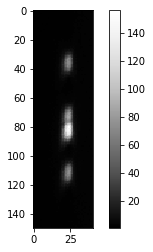

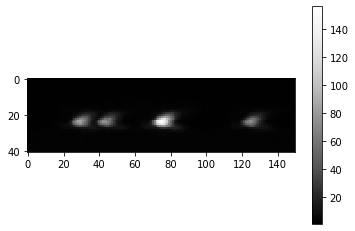

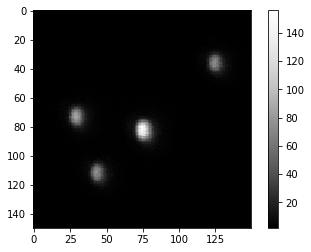

In [3]:
imshow(cle.maximum_x_projection(bead_image), colorbar=True)
imshow(cle.maximum_y_projection(bead_image), colorbar=True)
imshow(cle.maximum_z_projection(bead_image), colorbar=True)

为了确定平均PSF，从技术上讲，我们可以裁剪出所有单个珠子，对齐它们，然后对图像进行平均。因此，我们对对象进行分割并确定它们的质心。

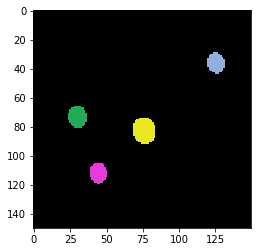

In [4]:
# 分割对象
label_image = cle.voronoi_otsu_labeling(bead_image)
imshow(label_image, labels=True)

In [5]:
# 确定每个对象的质心
stats = cle.statistics_of_labelled_pixels(bead_image, label_image)

df = pd.DataFrame(stats)
df[["mass_center_x", "mass_center_y", "mass_center_z"]]

mass_center_x  mass_center_y  mass_center_z
0      30.107895      73.028938      23.327475
1      44.293156     111.633430      23.329062
2      76.092850      82.453033      23.299677
3     125.439606      35.972496      23.390951

## PSF平均
接下来，我们将遍历珠子并通过将它们平移到较小的PSF图像中来裁剪它们。

Bead 0 at position 30.107894897460938 73.02893829345703 23.32747459411621
Bead 1 at position 44.293155670166016 111.63343048095703 23.32906150817871
Bead 2 at position 76.09284973144531 82.45303344726562 23.2996768951416
Bead 3 at position 125.43960571289062 35.972496032714844 23.39095115661621


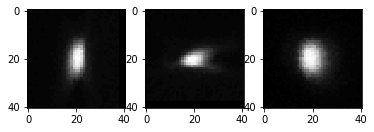

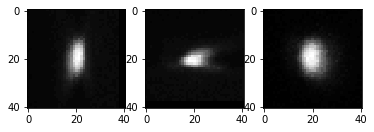

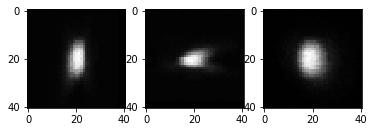

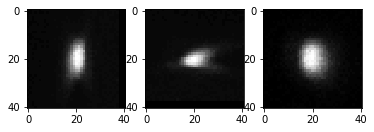

In [6]:
# 配置未来PSF图像的大小
psf_radius = 20
size = psf_radius * 2 + 1

# 初始化PSF
single_psf_image = cle.create([size, size, size])
avg_psf_image = cle.create([size, size, size])

num_psfs = len(df)
for index, row in df.iterrows():
    x = row["mass_center_x"]
    y = row["mass_center_y"]
    z = row["mass_center_z"]
    
    print("珠子", index, "位于位置", x, y, z)
    
    # 将PSF移动到较小图像中的正确位置
    cle.translate(bead_image, single_psf_image, 
                  translate_x= -x + psf_radius,
                  translate_y= -y + psf_radius,
                  translate_z= -z + psf_radius)

    # 可视化
    fig, axs = plt.subplots(1,3)    
    imshow(cle.maximum_x_projection(single_psf_image), plot=axs[0])
    imshow(cle.maximum_y_projection(single_psf_image), plot=axs[1])
    imshow(cle.maximum_z_projection(single_psf_image), plot=axs[2])
    
    # 平均
    avg_psf_image = avg_psf_image + single_psf_image / num_psfs

平均PSF看起来像这样：

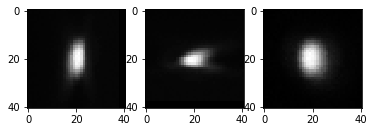

In [7]:
fig, axs = plt.subplots(1,3)    
imshow(cle.maximum_x_projection(avg_psf_image), plot=axs[0])
imshow(cle.maximum_y_projection(avg_psf_image), plot=axs[1])
imshow(cle.maximum_z_projection(avg_psf_image), plot=axs[2])

In [8]:
avg_psf_image.min(), avg_psf_image.max()

(0.0, 94.5)

在我们确定了一个位置良好的PSF之后，我们可以保存它以供以后重用。在这样做之前，我们对PSF进行归一化。目标是得到一个总强度为`1`的图像。这确保了稍后使用此PSF进行反卷积的图像不会修改图像的强度范围。

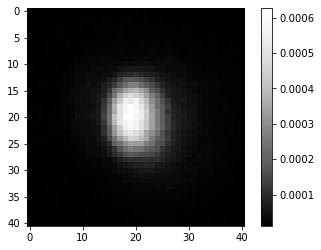

In [9]:
normalized_psf = avg_psf_image / np.sum(avg_psf_image)

imshow(normalized_psf, colorbar=True)

In [10]:
normalized_psf.min(), normalized_psf.max()

(0.0, 0.0006259646)

In [11]:
imsave('../../data/psf.tif', normalized_psf)

C:\Users\rober\AppData\Local\Temp\ipykernel_16716\3265681491.py:1: UserWarning: ../../data/psf.tif is a low contrast image
  imsave('../../data/psf.tif', normalized_psf)
